In [ ]:
"""
    script: JournalLDA.ipynb
    @author alan hamm(pqn7)

    resources:
        Applied Text Analysis with Python by Benjamin Bengfort, Rebecca Bilbro, 
        and Tony Ojeda(O'Reilly). 978-1-491-96304-3.

        https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html

"""

In [1]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader
import nltk.data
from nltk import sent_tokenize, pos_tag, wordpunct_tokenize
import en_core_web_lg
import gensim
from gensim.models import ldamulticore
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
# https://github.com/buriy/python-readability
from readability.readability import Unparseable
from readability.readability import Document as Paper

# https://docs.python.org/3/library/time.html
import time

# https://beautiful-soup-4.readthedocs.io/en/latest/
import bs4

# https://docs.python.org/3/library/codecs.html
import codecs

# https://docs.python.org/3/library/json.html
import json

import re 

import os

import pprint as pp

import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from time import time  # To time our operations

from sklearn.manifold import TSNE
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from matplotlib import pyplot as plt

import numpy as np

from tqdm import tqdm

import pandas as pd
#import modin.pandas as pd


import torch
from tqdm import tqdm
import csv

In [ ]:
#%%
# we create a list to contain the json files that are to be processed
# DOC_ID = ['mmsu_art_en_html.json']
#year = 2020
#DOC_ID=list()
#for x in os.listdir(r"C:/_harvester/data/html-by-year/20s"):
#    if x.endswith(".json") and x[:4] in ['2020']:
#        DOC_ID.append(x)
#print(DOC_ID)
DOC_ID =r'.*([\d]+_html\.json)'


# we create a list of categories/keywords/tags to
#cat_pattern = r'(.*)[\d]_html\.json'
#cat_pattern = r'(.*?)(\d{,4}?_html\.json'
#cat_pattern = r'(.*?)\d{,4}\.[\w]+'
CAT_PATTERN = r'^(.*?)[\W]*?\d{,4}?_html\.json'


# we mark the HTML tags to be used for 
# extacting the desired article, etc. text
# don't include 'li' tag e.g. <li>The Centers for Disease Control and Prevention (CDC) cannot attest to the accuracy of a non-federal website.</li>
TAGS = ['p']
#TAGS = ['h1']

# stop words
stop_words = stopwords.words('english')
# observed findings 
stop_words.extend(['icon', 'website', 'mmwr', 'citation', 'author', 'report', 'formatting', "format",'regarding',
                   'system', 'datum', 'link', 'linking', 'federal', 'data', 'tract', 'census', 'study',"question",
                   'conduct', 'report', 'including', 'top', 'summary', 'however', 'name', 'known',
                   'page', 'view', 'affiliation', 'pdf', 'law', 'version', 'list', 'endorsement', "review",
                   'article', 'download', 'reference', 'publication', 'discussion', 'table', 'vol', "message",
                   'information', 'web', 'notification', 'policy', 'policie', #spaCy lemmatization can make errors with pluralization(e.g. rabie for rabies)
                   'acknowledgment', 'altmetric',
                   'abbreviation', 'figure', "service","imply","current","source",
                   "trade","address", "addresses","program","organization" ,"provided", "copyrighted", "copyright",
                   "already", "topic", "art", 'e.g', 'eg'])

# pretrained model for POS tagging/filtering
nlp = en_core_web_lg.load( disable=['parser','ner'])

# set encoding for CorpusReader class
ENCODING = 'utf8'

# SET DIR PATHS
JSON_OUT = "C:/_harvester/data/json-outputs/"

# set the minimum number of topics to find
MIN_TOPICS = 100

# set the maximum number of topics to find
MAX_TOPICS = 505

# set the step by value
STEP_BY = 2

# set value to determine if lemmatization will be performed
LEMMATIZATION = True

In [ ]:

"""
Applied Text Analysis with Python by Benjamin Bengfort, Rebecca Bilbro, 
and Tony Ojeda(O'Reilly). 978-1-491-96304-3
"""

class JOURNALCorpusReader(CategorizedCorpusReader, CorpusReader):
    """ a corpus reader for CDC Journal articles """
    # class nltk.corpus.reader.api.CorpusReader
    # we explicitly specify the encoding as utf8 even though
    # the default is utf8
    def __init__(self, root, tags=TAGS, fileids=DOC_ID, encoding=ENCODING, **kwargs):
            
        # we use this check to see if the user specified any
        # values in the CAT_PATTERN list
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN
            #pp.pprint(kwargs)

        # initialize the NLTK  reader objects
        # review https://www.nltk.org/api/nltk.corpus.reader.api.html#nltk.corpus.reader.api.CategorizedCorpusReader to see
        # how __init__ is defined for each module; for the categorized
        # corpus reader, we use it to create categories if none are specified.
        CategorizedCorpusReader.__init__(self, kwargs)

        # https://www.nltk.org/api/nltk.corpus.reader.api.html#nltk.corpus.reader.api.CorpusReader
        # encoding –
        # The default unicode encoding for the files that make up the corpus. The value of encoding can 
        # be any of the following:
        #   A string: encoding is the encoding name for all files.
        #   A dictionary: encoding[file_id] is the encoding name for the file whose identifier is file_id. If file_id is not in encoding, 
        #       then the file contents will be processed using non-unicode byte strings.
        #   A list: encoding should be a list of (regexp, encoding) tuples. The encoding for a file whose 
        #       identifier is file_id will be the encoding value for the first tuple whose regexp matches
        #        the file_id. If no tuple’s regexp matches the file_id, the file contents will be processed using non-unicode byte strings.
        #   None: the file contents of all files will be processed using non-unicode byte strings.
        CorpusReader.__init__(self, root, fileids, encoding)
        
        #self.fileids = self.fileids()
        #self.categories = self.categories()
        self.tags = tags

        #print("From the constructor these are the fileids", fileids)
        #print("from the constructor these are the categories", self.categories)

    # we create a method that will allow us to filter how we
    # read the data from disk, either by specifying a list of categories
    # or a list of filenames
    def resolve(self, fileids=None, categories=None):
        #if fileids is not None and categories is not None:
        #   raise ValueError("Specify fileids or categories, not both")
            
        if categories is not None:
            #pp.pprint("This is a test of the resolve() method where categories is not None:")
            #pp.pprint(categories)
            #print("\n")

            return self.fileids(categories)
        
        #pp.pprint("This is a test of the resolve() method where fileids is not None:")
        #pp.pprint(fileids)
        #print("\n")

        return fileids

    # we use this method to read all values from the key-value objects,
    # concatenating them into a list object which is returned.
    def docs(self,fileids=None, categories=None):

        fileids = self.resolve(self.fileids(), self.categories())
        #for f in fileids:
        #    pp.pprint( f)
        
        # https://docs.python.org/3/library/codecs.html
        # This module defines base classes for standard Python codecs 
        # (encoders and decoders) and provides access to the internal Python 
        # codec registry, which manages the codec and error handling 
        # lookup process. Most standard codecs are text encodings, which encode 
        # text to bytes (and decode bytes to text), but there are also codecs 
        # provided that encode text to text, and bytes to bytes. Custom codecs 
        # may encode and decode between arbitrary types, but some module features 
        # are restricted to be used specifically with text encodings or with codecs 
        # that encode to bytes.

        # A string in Python is a sequence of Unicode code points (in range U+0000–U+10FFFF). To store or 
        # transfer a string, it needs to be serialized as a sequence of bytes.
        # Serializing a string into a sequence of bytes is known as “encoding”, 
        # and recreating the string from the sequence of bytes is known as “decoding”.
        # There are a variety of different text serialization codecs, which are collectively 
        # referred to as “text encodings”.

        # codecs.open(filename, mode='r', encoding=None, errors='strict', buffering=-1)
        # Open an encoded file using the given mode and return an instance of StreamReaderWriter, 
        # providing transparent encoding/decoding. The default file mode is 'r', meaning to open 
        # the file in read mode.
        # Note If encoding is not None, then the underlying encoded files are always opened in binary 
        # mode. No automatic conversion of '\n' is done on reading and writing. The mode argument
        # may be any binary mode acceptable to the built-in open() function; 
        # the 'b' is automatically added.
        
        # abspaths() Return a list of the absolute paths for all fileids in this corpus; 
        #       or for the given list of fileids, if specified.
        for path, encoding in self.abspaths(self.fileids(), include_encoding=True):
            with codecs.open(path, 'r', encoding=encoding) as f:
                yield json.load(f)
                    #data = json.load(f)
                    #docbag.append(str(data))

        #pp.pprint(docbag)
        #yield docbag


    # we use this method to to parse the HTML
    def html(self, fileids=None, categories=None):
        for idx, doc in enumerate(self.docs(fileids, categories)):
            pp.pprint(f"The file {self.fileids()[idx]} is being processed in HTML()")
            for sentence in doc:
                try:
                    #pp.pprint(line)
                    #print("\n")
                    yield Paper(sentence).summary() # summer() Given an HTML file, extracts the text of the article
                except Unparseable as e:
                    print("Could not parse HTML: {}".format(e))
                    print(f"the fileid {self.fileids()[idx]}")
                    pp.pprint(sentence)
                    print("\n")
                    continue
            
    def paras(self, fileids=None, categories=None):
        for html in self.html(fileids, categories):
            soup=bs4.BeautifulSoup(html,'html.parser')
            for element in soup.find_all(TAGS):
                if re.search(r'[a-zA-Z]+', element.text) and not re.search(r'(vol)', element.text, re.IGNORECASE):
                    yield element.text
            soup.decompose()
                    
    def sents(self, fileids=None, categories=None):
        for paragraph in self.paras(fileids, categories):
            for sentence in sent_tokenize(paragraph):
                yield sentence

    def words(self, fileids=None, categories=None):
        for sentence in self.sents(fileids, categories):
            for token in wordpunct_tokenize(sentence):
                yield token
    
    """
    def tokenize(self, fileids=None, categories=None):
        for paragraph in self.paras(fileids, categories):
            yield[
                    pos_tag(wordpunct_tokenize(sent))
                    for sent in sent_tokenize(paragraph)
                    ]    
    """

    def generate(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time()

        #structures to perform counting
        counts = nltk.FreqDist()
        tokens = nltk.FreqDist()

        para_dict = dict()
        for idx, para in tqdm(enumerate(self.paras()), desc='loading para()', total=1334992):
            para_dict[idx] = para
            counts['paras'] += 1

        sent_dict = dict()          
        for idx, sent in tqdm(enumerate(self.sents()), desc='loading sents()', total=183123):
            sent_dict[idx] = sent
            counts['sents'] += 1

        word_dict = dict()            
        for idx, word in tqdm(enumerate(self.words()), desc='loading words()', total=17960452): 
            word_dict[idx] = word
            counts['words'] += 1
            tokens[word] += 1  

        #compute  the number of files and categories in the corpus
        n_fileids = len(self.resolve(fileids, categories) or self.fileids())
        #n_fileids = len(fileids)
        #n_topics = len(self.categories(self.resolve(fileids, categories)) or self.categories)
        #n_topics = len(categories)
        
        #return data structure with information
        meta = {
                'files': self.fileids(),
                # number of files
                'nfiles': n_fileids,
                # number of topics
                #'topics': n_topics,
                # number of paragraphs
                'paras': counts['paras'],
                # number of sentences
                'sents': counts['sents'],
                # number of words
                'words': counts['words'],
                # size of vocabulary ie number of unique terms
                'vocab': len(tokens),
                # lexical diversity, the ratio of unique terms to total words
                'lexdiv': float(counts['words']) / float(len(tokens)),
                # average number of words per sentence
                'wdps': float(counts['words']) / float(counts['sents']),
                # average number of sentences per paragraph
                'sppar': float(counts['sents']) / float(counts['paras']),
                # total processing time
                'mins': round((time() - started) / 60, 2)
                }
        return meta, para_dict, sent_dict, word_dict, counts, tokens


In [ ]:
# resource: https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html
import plotly.offline as py
import plotly.graph_objs as go
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models. Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=750, height=750, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

try:
    get_ipython()
    import plotly.offline as py
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
    print("The module PlotLy was not imported")
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

In [ ]:
_corpus = JOURNALCorpusReader('/_harvester/data/html-by-year/10s')
#print(_corpus.categories())
_corpus.fileids()

In [ ]:
corpus_tuple = _corpus.generate()
# loading describe(): 100%|██████████| 10/10 [31:58<00:00, 191.86s/it]

In [ ]:
pp.pprint(corpus_tuple[0])


### 04092024
{'files': ['2010_html.json', '2011_html.json', '2012_html.json', '2013_html.json', '2014_html.json',\
           '2015_html.json', '2016_html.json', '2017_html.json', '2018_html.json', '2019_html.json']\
           
 'lexdiv': 252.79376416454915,\
 'mins': 215.82,\
 'nfiles': 10,\
 'paras': 8694722,\
 'ppdoc': 869472.2,\
 'sents': 9073055,\
 'sppar': 1.0435129495802167,\
 'vocab': 116488,\
 'wdps': 3.245592581550536,\
 'words': 29447440}

 ### 04102024
 {'files': ['2010_html.json', '2011_html.json', '2012_html.json', '2013_html.json', '2014_html.json',\
           '2015_html.json', '2016_html.json', '2017_html.json', '2018_html.json', '2019_html.json']\
           
 'lexdiv': 159.46702418581526,\
 'mins': 90.67,\
 'nfiles': 10,\
 'paras': 1334992,\
 'sents': 1739711,\
 'sppar': 1.3031621163272888,\
 'vocab': 112628,\
 'wdps': 10.32381355294069,\
 'words': 17960452}

In [ ]:
from tqdm import tqdm
t = time()

texts_out= list()
inner_text = list()

# number of stopwords found
stopword_count = nltk.FreqDist()

pp.pprint("Executing POS/LEMMATIZATION")

#pbar = tqdm(total=8694722)
for idx, paras in tqdm(corpus_tuple[1].items(), desc='creating tokenized sents', total=len(corpus_tuple[1])):
    doc = nlp(paras)
    #pp.pprint(paras)
    #print("\n")
    
    for token in doc:
        if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
            if len(token.text) > 1:
                #pp.pprint(token.text)
                #spaCy can make errors with lemmatization so we check using lemma_ and not using lemma_
                if token.text.lower() not in stop_words and token.lemma_.lower() not in stop_words: 
                    if LEMMATIZATION == False:
                        # don't use lemma_ so as to allow robust contextualization(e.g. Black race versus black)
                        inner_text.append(token.text) 
                    else:
                        inner_text.append(token.lemma_) 
                else:
                    if LEMMATIZATION == False:
                        stopword_count[token.text]+=1
                    else:
                        stopword_count[token.lemma_]+=1

            #pp.pprint(texts_out) 
    if len(inner_text) > 0:
        texts_out.append(inner_text)
    inner_text = []

    #pbar.update(1)
#pbar.close()
pp.pprint('Time to finish spaCy filter: {} mins'.format(round((time() - t) / 60, 2)))

#pp.pprint(texts_out[0:25])

# tokenizing sentence content: 100%|██████████| 23883/23883 [02:35<00:00, 153.49it/s]
# 04092024 - 100%|█████████▉| 8694712/8694722 [3:42:50<00:00, 216.60it/s]
# 04102024 - creating tokenized sents: 100%|██████████| 1334992/1334992 [39:04<00:00, 569.49it/s] 

In [ ]:
# return table of FreqDist object
pp.pprint(stopword_count.tabulate())
print("\n")

In [ ]:
# https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type
import pickle
with open(r"C:\_harvester\data\lda-models\2010s_html.json\tokenized_sents-w0-bigrams.pkl", "wb") as fp:
    pickle.dump(texts_out, fp)

In [ ]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts_out, min_count=20)

# freqDist object for bigrams
bigram_freq = nltk.FreqDist()

# print bigrams
for ngrams, _ in bigram.vocab.items():
    #unicode_ngrams = ngrams.decode('utf-8')
    if '_' in ngrams:
        bigram_freq[ngrams]+=1
        print(ngrams)

# add bigrams to texts_out to be included in corpus
for idx in range(len(texts_out)):
    for token in bigram[texts_out[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts_out[idx].append(token)

In [2]:
#tokenized_sents = pd.DataFrame(texts_out)
#tokenized_sents.to_parquet(r"C:\_harvester\data\lda-models\2010s_html.json\tokenized_sents-w-bigrams.parquet")

import pickle
with open(r"C:\_harvester\data\lda-models\2010s_html.json\word2vec-2010s\tokenized-texts-out\tokenized_sents-w-bigrams.pkl", "rb") as fp:
    texts_out = pickle.load(fp)
print(texts_out[:25])

[['contain', 'depth', 'relay', 'statement', 'prevention', 'treatment', 'area', 'scope', 'responsibility', 'e.g.', 'recommendation'], ['surveillance', 'provide', 'means', 'disseminate', 'surveillance', 'finding', 'permit', 'detailed', 'interpretation', 'trend', 'pattern', 'base', 'finding'], ['person', 'use', 'assistive', 'technology', 'able', 'fully', 'access', 'file', 'assistance', 'send', 'mail', 'type', 'title', 'subject', 'line', 'mail', 'use_assistive', 'technology_able', 'fully_access', 'file_assistance', 'send_mail', 'type_title', 'subject_line'], ['annually', 'publish', 'immunization', 'schedule', 'person', 'age', 'year', 'summarize', 'recommendation', 'currently', 'license', 'vaccine', 'child', 'age', 'year', 'young', 'include', 'recommendation', 'effect', 'change', 'previous', 'schedule', 'include', 'following', 'immunization_schedule', 'age_year', 'age_year'], ['require', 'health', 'care', 'provider', 'provide', 'parent', 'patient', 'copy', 'administer', 'dose', 'vaccine', '

In [3]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# create training data
#training_texts_out = texts_out[0:int(len(texts_out)*.7)]

# Create Dictionary
id2word = Dictionary(texts_out)
#id2word_training = Dictionary(training_texts_out)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=100, no_above=0.5) #NOTE: these thresholds won't be met bc at most there are 10 docs ie 1 doc per year
#id2word_training.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [id2word.doc2bow(text) for text in texts_out]
#corpus_training = [id2word_training.doc2bow(text) for text in training_texts_out]

#pp.pprint(corpus[0:25])

In [ ]:
# https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html
# print(gensim.models.ldamulticore.LdaMulticore.diff.__doc__)

#m1 = gensim.models.ldamulticore.LdaMulticore.load(r"C:/_harvester/data/lda-models/2020_html.json/lda_25/lda_25.model")
#m2 = gensim.models.ldamulticore.LdaMulticore.load(r"C:/_harvester/data/lda-models/2020_html.json/lda_50/lda_50.model")
#mdiff, annotation = m1.diff(m2)
#topic_diff = mdiff  # get matrix with difference for each topic pair from `m1` and `m2`
#plot_difference(mdiff, annotation=annotation)

In [ ]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
#from gensim.models import CoherenceModel

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=m2, texts=texts_out, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('Coherence Score: ', coherence_lda)

[Source](https://www.meganstodel.com/posts/callbacks/)
Metrics to look at with callbacks
These are the metrics provided in existing gensim callback classes.

Coherence
A measure of similarity between top scoring words in topics. The version used here is c_v coherence. Scores are between 0 and 1. Closer to 1 is better.

Perplexity
Perplexity is a statistical measure giving the normalised log-likelihood of a test set held out from the training data. The figure it produces indicates the probability of the unseen data occurring given the data the model was trained on. The higher the figure, the more ‘surprising’ the new data is, so a low score suggests a model that adapts better to unseen data.

However, a 2009 study found that perplexity and human judgment are often not correlated. So depending on what we want, this might not be the best metric.

Topic diff
This metric considers the difference between subtopics produced by the same model (in this case the model at the given number of passes). It is the mean of how unique the top words of each subtopic are compared with all the other subtopics. Where all the top words are totally unique for all subtopics, the score would be 1.

This can be quite a hygienic metric - basically you don’t want your model to do badly on this, but as long as it does well you would probably use other metrics to finalise your decision.

Convergence
The convergence score provided by the callbacks class relates to topic convergence. In practice, this means it is the sum of the topic diff scores, so normally it isn’t necessary to run both.

To compare models with different numbers of topics, these should be normalised - for example, finding the average topic diff by dividing the convergence score by the topic number.

In [4]:
### choose the callbacks classes to import
import logging
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric
from gensim.models import CoherenceModel


[Source](https://towardsdatascience.com/c%E1%B5%A5-topic-coherence-explained-fc70e2a85227)
### Coherence scores are a combination of...
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Segmentation of word subsets,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Probability estimation,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Confirmation measure,\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Aggregation.

### Cᵥ Coherence
In cᵥ coherence, each topic word is compared with the set of all topics. A boolean sliding window of size 110 is used to assess whether two words co-occur. Then, the confirmation measure consists of direct- and indirect confirmations. For all N most probable words per topic, a ‘word vector’ of size N is created in which each cell contains the Normalized Pointwise Mutual Information (NPMI) between that word and word i, i in{1,2,…, N}. Then, all the word vectors in a topic are aggregated into one big topic vector. The average of all the cosine similarities between each topic word and its topic vector (this is the segmentation) is used to calculate the Cᵥ score. \
NOTE: [Pointwise Mutual Information](https://medium.com/dataseries/understanding-pointwise-mutual-information-in-nlp-e4ef75ecb57a) "The answer lies in the Pointwise Mutual Information (PMI) criterion. The idea of PMI is that we want to quantify the likelihood of co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. Hence, the algorithm computes the (log) probability of co-occurrence scaled by the product of the single probability of occurrence."

### [Coherence Measures](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Gensim%27s%20Phrases%20model%20can%20build,for%20words%20to%20be%20combined.)
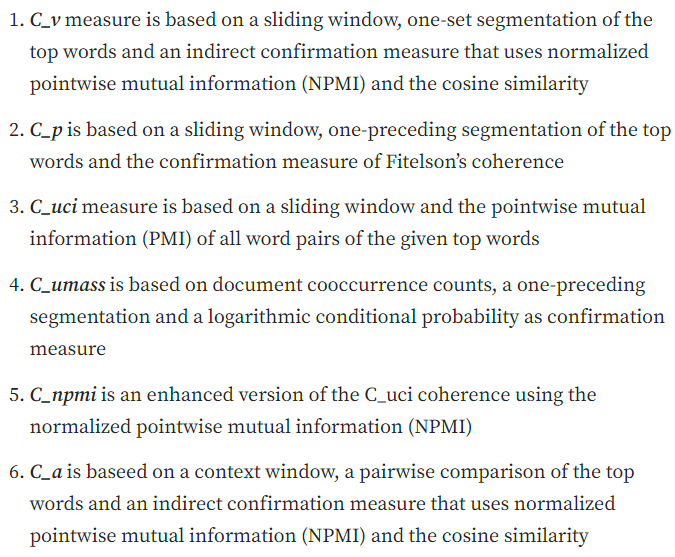 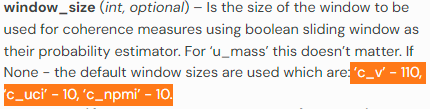

[Source](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8) Dirichlet distributions allow for \
probability distribution sampling over a probability simplex in which all the numbers add up to 1, and these numbers represent \
probabilities over K distinct categories. A K-dimensional Dirichlet distribution has k-parameters and represents uncertainty as \
a probability distribution. The Dirichlet prior parameters 𝛂 and 𝛃 are corpus-level parameters that are sampled once in the process \
of generating a corpus, and parameter 𝚹ₘ is a document-level variable that is sampled once per document. Variables zₘₙ and wₘₙ are word-level \
variables that are sampled once for each word in each document. Lastly, 𝛗ₖ represents the word probability distribution for a topic k.

The perplexity metric in NLP is a way to capture the degree of ‘uncertainty’ a model has in predicting (i.e. assigning probabilities to) text. \

In information theory, perplexity is a measure of uncertainty in the value of a sample from a discrete probability distribution. The larger the \
perplexity, the less likely it is that an observer can guess the value which will be drawn from the distribution.

The LDA makes two key assumptions:

Documents are a mixture of topics, and \
Topics are a mixture of tokens (or words) \
And, these topics using the probability distribution generate the words. In statistical language, \
the documents are known as the probability density (or distribution) of topics and the topics \
are the probability density (or distribution) of words.

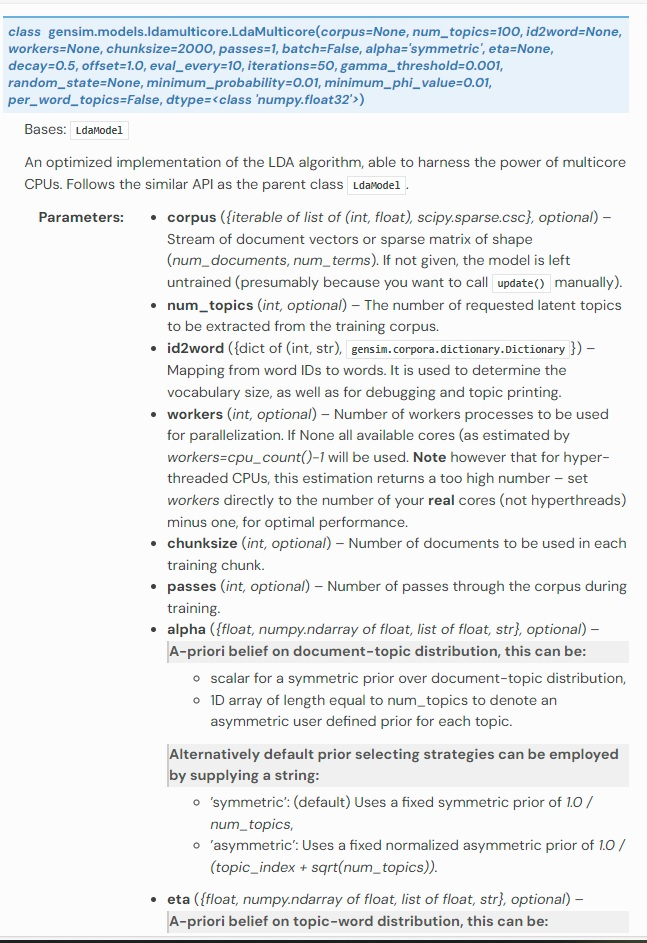 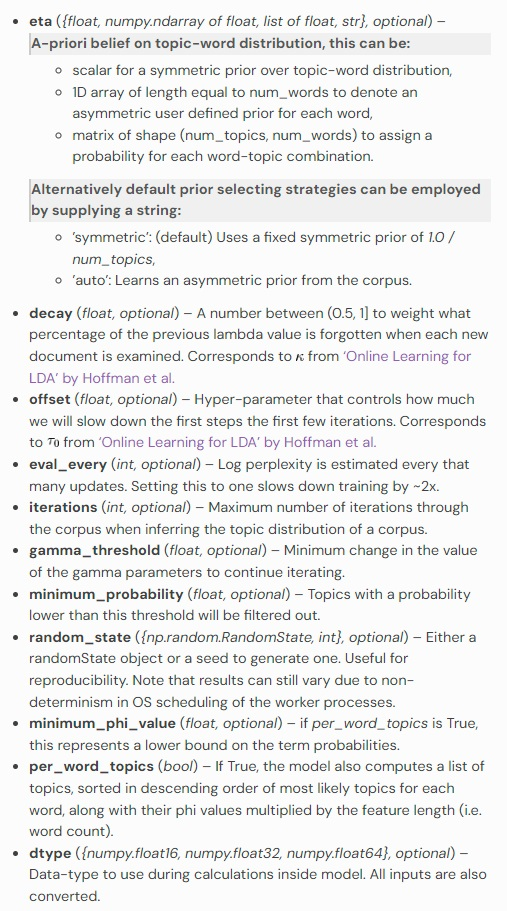

[Source](https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920): LDA’s approach to topic
modeling is, it considers each document as a collection of topics and each topic as collection of keywords. Once you provide \
the algorithm with number of topics all it does is to rearrange the topic distribution within documents and key word \
distribution within the topics to obtain good composition of topic-keyword distribution.

Rho(learning rate) is the speed of updating - controls how much a new chunk influences the result.

"Topic diff" is how much the topics changed after this EM iteration. No change would indicate that the model has converged.

Topic Difference \
Topic Diff calculates the distance between two LDA models. This distance is calculated based on \
the topics, by either using their probability distribution over vocabulary words (kullback_leibler, hellinger) \
or by simply using the common vocabulary words between the topics from both model.

Convergence(see Gamma Threshold option) \
Convergence is the sum of the difference between all the identical topics from \
two consecutive epochs. It is basically the sum of column values in the heatmap above.

In [6]:
# ttps://radimrehurek.com/gensim/models/ldamulticore.html
# https://radimrehurek.com/gensim/models/ldamodel.html

# supporting function
cores = multiprocessing.cpu_count() - 1 # Count the number of cores in a computer
from gensim.models import CoherenceModel

"""
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           #eval_every=5, # using this option set to 1 doubles the execution time
                                           workers=cores,
                                           random_state=100,
                                           #chunksize = 5000, # value significantly increases time to completion
                                           chunksize=int(len(corpus)/cores+1),
                                           passes=50,
                                           iterations=100,
                                           alpha=a, # A-priori belief on topic-document distribution "topic distribution within document", controls the sparsity of the document-topic distribution
                                           eta=b, # A-priori belief on word-topic distribution "word distribution within topic", controls the sparsity of the topic-word distribution
                                           per_word_topics=True
                                        ) 
"""
# Set up the callbacks loggers
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = texts_out)

# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
def compute_coherence_values(corpus, dictionary, k, a, b, iteration):
    # Add text to logger to indicate new model
    logging.debug(f'Start of model: {k} topics')

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
            num_topics=k,
            eval_every=20,
            passes=5, # viewed the log for iteration 1, pass at n=5 showed a relatively high coherence value; therefore not using large n(e.g. 50)
            iterations=100,
            random_state=75,
            chunksize=int(len(corpus)/cores+1),
            alpha=a,
            eta=b,
            per_word_topics= True,
            callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger]
        )
    

    # Add text to logger to indicate end of this model
    logging.debug(f'End of model: {k} topics')



    
    # Save models so they aren't lost
    if not os.path.exists(f"C:/_harvester/data/lda-models/2010s_html.json/lda-corpusset({iteration})/lda_{k}_topics/"):
        os.makedirs(f"C:/_harvester/data/lda-models/2010s_html.json/lda-corpusset({iteration})/lda_{k}_topics/")

    lda_model.save(f"C:/_harvester/data/lda-models/2010s_html.json/lda-corpusset({iteration})/lda_{k}_topics/alpha({a})-beta({b}).model")
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_out, dictionary=id2word, coherence='c_v')

    convergence_score = lda_model.bound(corpus)


    return coherence_model_lda.get_coherence(), lda_model.log_perplexity(corpus), convergence_score

[Coherence Model Documentation](https://radimrehurek.com/gensim/models/coherencemodel.html) \
[Coherence Model Explained]( https://towardsdatascience.com/c%E1%B5%A5-topic-coherence-explained-fc70e2a85227) \
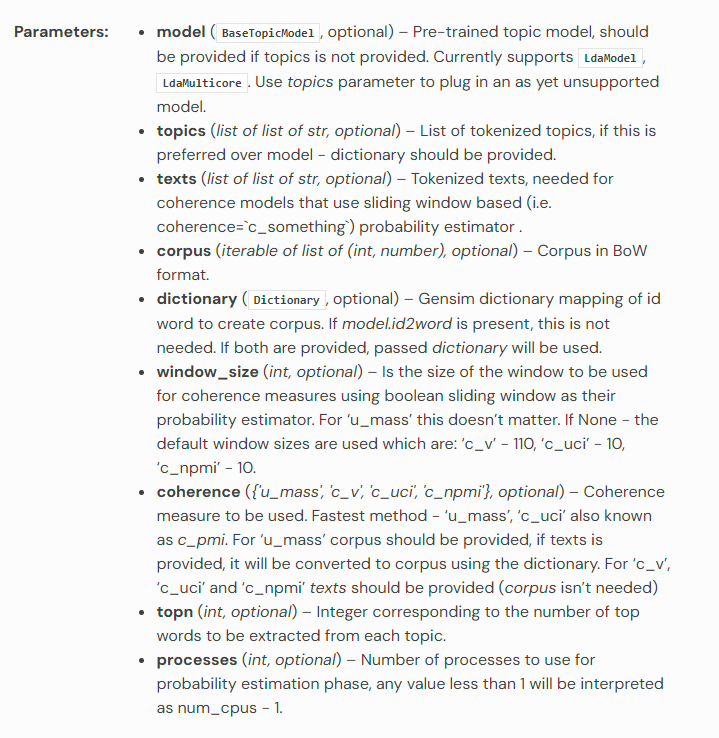

[gensim log_perplexity()](https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaModel.log_perplexity.html) \
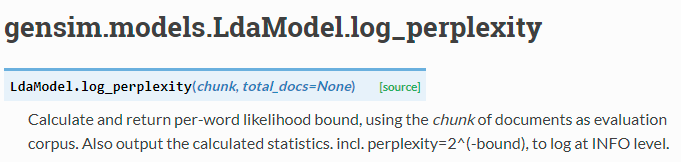

[Wikipedia Perplexity Explained](https://en.wikipedia.org/wiki/Perplexity#Perplexity_per_word) \
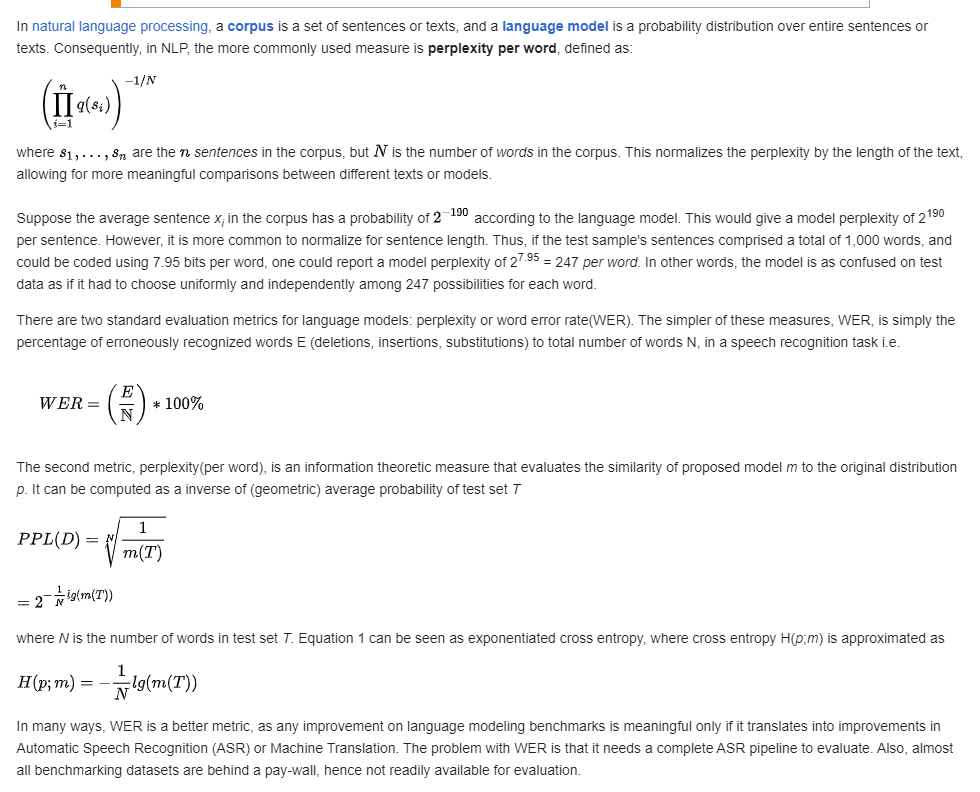


In [7]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# If the file already exists, the log will continue rather than being overwritten.
# create log file to view log perplexity, topics, etc.
import logging
logging.basicConfig(filename=f"C:/_harvester/data/lda-models/2010s_html.json/model_callback.log",
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 100
max_topics = 305
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
beta.append('asymmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': [],
                 'Convergence': []
                }

# Can take a long time to run
if 1 == 1:
    # Set up GPU device
    device = torch.device("cuda")
    
    # Initialize CSV file to store results
    with open(r'C:\_harvester\data\lda-models\2010s_html.json\results\topic_analysis_results.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Num Topics', 'Alpha', 'Beta', 'Coherence', 'Log Perplexity', 'Convergence Score'])

    pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:

            # iterate through alpha values
            for a in alpha:

                # iterare through beta values
                for b in beta:
                    
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b, iteration=i)
                    
                    cv.to(device)  # Move model to GPU

                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv[0])
                    model_results['Perplexity'].append(cv[1])
                    model_results['Convergence'].append(cv[2])
                    #pp.pprint(model_results)

                    # Write results to CSV file
                    writer.writerow([k, a, b, cv[0], cv[1], cv[2]])

                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_pickle('C:/_harvester/data/lda-models/2010s_html.json/results/2010s-lda_tuning_results.pkl')
    pd.DataFrame(model_results).to_csv('C:/_harvester/data/lda-models/2010s_html.json/results/2010s-lda_tuning_results.csv', index=False)
    pbar.close()

logging.shutdown()
# 2020 - 100%|██████████| 480/480 [16:51:09<00:00, 126.40s/it]  9 to 25 topics by 2, included 'li' html tag
# 2020 - 100%|██████████| 1800/1800 [43:06:14<00:00, 86.21s/it], topics range -> range(25, 65, by 2) note: 'li' tag was 


  0%|          | 0/1476 [00:00<?, ?it/s]

In [ ]:
logging.shutdown()

In [ ]:
pd.DataFrame(model_results).to_pickle('C:/_harvester/data/lda-models/2020_html.json/results/2020-lda_tuning_results.pkl')
pd.DataFrame(model_results).to_csv('C:/_harvester/data/lda-models/2020_html.json/results/2020-lda_tuning_results.csv', index=False)

In [ ]:
"""
log_file_path = "C:/_harvester/data/lda-models/2020_html.json/model_callbacks.log"
with open(log_file_path, 'r') as file:
    log_data = file.read()

perplexity_scores = re.findall(r'Perplexity estimate: (\d+\.\d+)', log_data)
model_results['perplexity'] = 
"""

### Plot Coherence

In [ ]:
# https://dataknowsall.com/blog/topicmodels.html
# https://medium.com/the-researchers-guide/introduction-to-line-plot-matplotlib-pandas-and-seaborn-visualization-guide-part-1-1e69cd0b71f1
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline


# get coherence values
df = pd.read_pickle('C:/_harvester/data/lda-models/2020_html.json/results/2020-lda_tuning_results.pkl')
df['Perplexity'] = 2**(-1*df['Perplexity'])
df = df[df['Coherence'] > .6]
dfone=df[df['Validation_Set'] == '1/3 Corpus' ] # 1/3 of corpus
dftwo=df[df['Validation_Set'] == '2/3 Corpus' ] # 2/3 of corpus
dfthree=df[df['Validation_Set'] == '3/3 Corpus' ] # 3/3 % of corpus


plt.figure(figsize=(8,5))

# Topics range
min_topics = MIN_TOPICS
max_topics = MAX_TOPICS
step_size = STEP_BY
topics_range = range(min_topics, max_topics, step_size)

# Create a custom x-axis
x = range(min_topics, max_topics, step_size)

# Build the line plot
ax = sns.lineplot(data=df[df['Coherence'] > .6], x='Topics', y='Coherence', color='#238C8C', hue='Validation_Set')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(min_topics, max_topics)
plt.xticks(range(min_topics, max_topics, step_size))

# Add a vertical line to show the optimum number of topics
max_coherency = dfthree[dfthree['Coherence'] > .6].sort_values(by=['Coherence', 'Perplexity'], ascending=[ False, True]).iloc[:50]
pp.pprint(dfthree)

plt.axvline(dfthree['Topics'].iloc[0], 
            color='#F26457', linestyle='--')


# Draw a custom legend
#legend_elements = [Line2D([0], [0], color='#238C8C', 
#                          ls='-', label='Coherence Value (c_v)'),
#                   Line2D([0], [1], color='#F26457', 
#                         ls='--', label='Optimal Number of Topics')]

#ax.legend(handles=legend_elements, loc='upper right')

### Plot Perplexity

In [ ]:
%matplotlib inline

# get perplexity values
df = pd.read_pickle('C:/_harvester/data/lda-models/2020_html.json/results/2020-lda_tuning_results.pkl')
df['Perplexity'] = 2**(-1*df['Perplexity'])
df = df[df['Coherence'] > .6]
dfone=df[df['Validation_Set'] == '1/3 Corpus' ] # 1/3 of corpus
dftwo=df[df['Validation_Set'] == '2/3 Corpus' ] # 2/3 of corpus
dfthree=df[df['Validation_Set'] == '3/3 Corpus' ] # 3/3 % of corpus

plt.figure(figsize=(8,5))

# Topics range
min_topics = MIN_TOPICS
max_topics = MAX_TOPICS
step_size = STEP_BY
topics_range = range(min_topics, max_topics, step_size)

# Create a custom x-axis
x = range(min_topics, max_topics, step_size)

# Build the line plot
ax = sns.lineplot(data=dfthree, x='Topics', y='Perplexity', color='#238C8C', hue='Validation_Set')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.xlim(min_topics, max_topics)
plt.xticks(range(min_topics, max_topics, step_size))

# Add a vertical line to show the optimum number of topics
min_perplexity = dfthree[dfthree['Coherence'] > .6].sort_values(by=['Perplexity'], ascending=[ True]).iloc[:25]
pp.pprint(min_perplexity[min_perplexity['Coherence'] > .6])

plt.axvline(min_perplexity['Topics'].iloc[0], 
            color='#F26457', linestyle='--')

# Draw a custom legend
#legend_elements = [Line2D([0], [0], color='#238C8C', 
#                          ls='-', label='Perplexity'),
#                   Line2D([0], [1], color='#F26457', 
#                          ls='--', label='Optimal Number of Topics')]

#ax.legend(handles=legend_elements, loc='upper right')

In [ ]:
# https://dataknowsall.com/blog/topicmodels.html
# https://medium.com/the-researchers-guide/introduction-to-line-plot-matplotlib-pandas-and-seaborn-visualization-guide-part-1-1e69cd0b71f1
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline


# get coherence values
df = pd.read_pickle('C:/_harvester/data/lda-models/2020_html.json/results/2020-lda_tuning_results.pkl')
df['Perplexity'] = 2**(-1*df['Perplexity'])
df = df[df['Coherence'] > .6]
dfone=df[df['Validation_Set'] == '1/3 Corpus' ] # 1/3 of corpus
dftwo=df[df['Validation_Set'] == '2/3 Corpus' ] # 2/3 of corpus
dfthree=df[df['Validation_Set'] == '3/3 Corpus' ] # 3/3 % of corpus


plt.figure(figsize=(8,5))

# Topics range
min_topics = MIN_TOPICS
max_topics = MAX_TOPICS
step_size = STEP_BY
topics_range = range(min_topics, max_topics, step_size)

# Create a custom x-axis
#x = range(min_topics, max_topics, step_size)

# Build the line plot
ax = sns.lineplot(data=df, x='Topics', y='Perplexity', color='#238C8C', hue='Validation_Set')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Alpha Values")
plt.ylabel("Coherence score")
#plt.xlim(min_topics, max_topics)
#plt.xticks(range(min_topics, max_topics, step_size))

# Add a vertical line to show the optimum number of topics
max_coherency = df.sort_values(by=['Topics', 'Perplexity'], ascending=[ False, True]).iloc[:25]
pp.pprint(max_coherency)

plt.axvline(max_coherency['Topics'].iloc[0], 
            color='#F26457', linestyle='--')


# Draw a custom legend
#legend_elements = [Line2D([0], [0], color='#238C8C', 
#                          ls='-', label='Coherence Value (c_v)'),
#                   Line2D([0], [1], color='#F26457', 
#                         ls='--', label='Optimal Number of Topics')]

#ax.legend(handles=legend_elements, loc='upper right')

In [ ]:
from gensim.test.utils import datapath
topics_27_saved = datapath("/_harvester/data/lda-models/2020_html.json/lda-corpusset(2)/lda_27_topics/alpha(0.9099999999999999)-beta(0.61).model")
lda_27_topics = gensim.models.ldamodel.LdaModel.load(topics_27_saved)

In [ ]:
# load id2word and create corpus
id2word = corpora.Dictionary.load(f'/_harvester/data/lda-models/2020_html.json/lda-corpusset(1)/lda_27_topics/alpha(0.9099999999999999)-beta(0.61).model.id2word')

In [ ]:
#Creating Topic Distance Visualization
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_27_topics, corpus, id2word)

In [ ]:
from gensim.test.utils import datapath
topics_63_saved = datapath("/_harvester/data/lda-models/2020_html.json/lda-corpusset(1)/lda_63_topics/alpha(symmetric)-beta(0.61).model")
lda_63_topics = gensim.models.ldamodel.LdaModel.load(topics_63_saved)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_63_topics, corpus, id2word)